In [ ]:
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

## Dataset

In [ ]:
if not os.path.exists('lfwcrop_grey'):
    !wget http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip
    !unzip 'lfwcrop_grey.zip'

filenames = []
images = []

for filename in os.listdir('lfwcrop_grey/faces'):
    filenames.append(filename)
    image = np.array(Image.open(os.path.join('lfwcrop_grey/faces', filename)))
    images.append(image)

images = np.array(images)

print('Total Number of Faces: {}'.format(len(images)))
print(images.shape)

X = images.reshape(13233, 64*64)
print(X.shape)

Total Number of Faces: 13233
(13233, 64, 64)
(13233, 4096)


## Visualize the Dataset

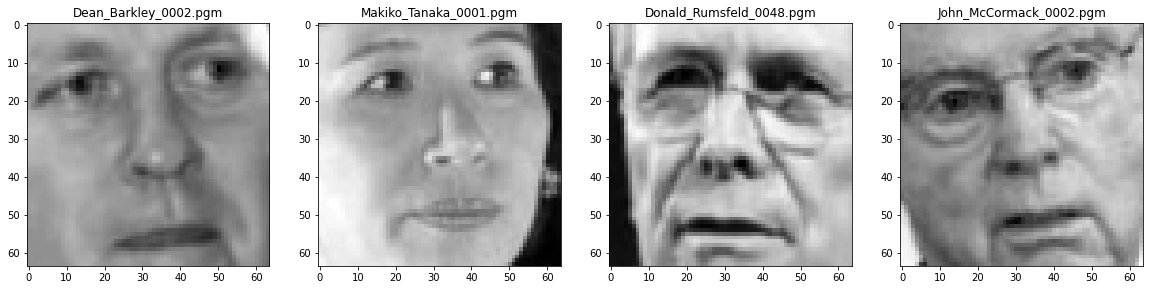

In [ ]:
plt.figure(figsize=(20, 10))
num_images = 4
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    index = np.random.choice(range(len(images)))
    image = images[index]
    filename=filenames[index]
    plt.imshow(image, 'gray')
    plt.title(filename)

## Find the Eigenvectors and Eigenvalues of Covariance Matrix

In [ ]:
# Compute the covariance matrix (784x784 since we have 784D data)
covariance_matrix = np.cov(X.T)

# The column of the eigenvector matrix are the eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)



(4096, 4096)


## Sort the eigenvalues and eigenvectors

In [ ]:
# Create  (eigenvalue, eigenvector) tuple
# eigenvectors[:,i] implies we are selecting a column, not row
eigen_pair = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]

# Sort the pairs according to decreasing eigenvalues
eigen_pair.sort(key=lambda x: x[0], reverse=True)

## Select the required dimensions to retain a percentage of variance
Expained Variance  tells you how much information (variance) can be attributed to each of the principal components.

The eigenvalues represent the variance in the data along that dimension. 

In [ ]:
# Percentage of variance to keep
keep_variance=0.99

required_variance = keep_variance * sum(eigenvalues)

required_dim = 0
variance = 0
for i in range(len(eigen_pair)):
    variance += eigen_pair[i][0]
    if variance >= required_variance:
        required_dim = i + 1
        break

print('Total Dimensions: {}'.format(len(eigen_pair)))
print('Required Dimensions: {}'.format(required_dim))

Total Dimensions: 4096
Required Dimensions: 577


## Generate Projection Matrix
The projection matrix will contain the eigen vectors or basis as its columns.

In [ ]:
projection_matrix = np.empty(shape=(X.shape[1], required_dim))

for index in range(required_dim):
    eigenvector = eigen_pair[index][1]
    projection_matrix[:, index] = eigenvector

print('Projection Matrix Shape: \n {}'.format(projection_matrix.shape))

Projection Matrix Shape: 
 (4096, 577)


## Visualize the Eigen Faces (Templates)

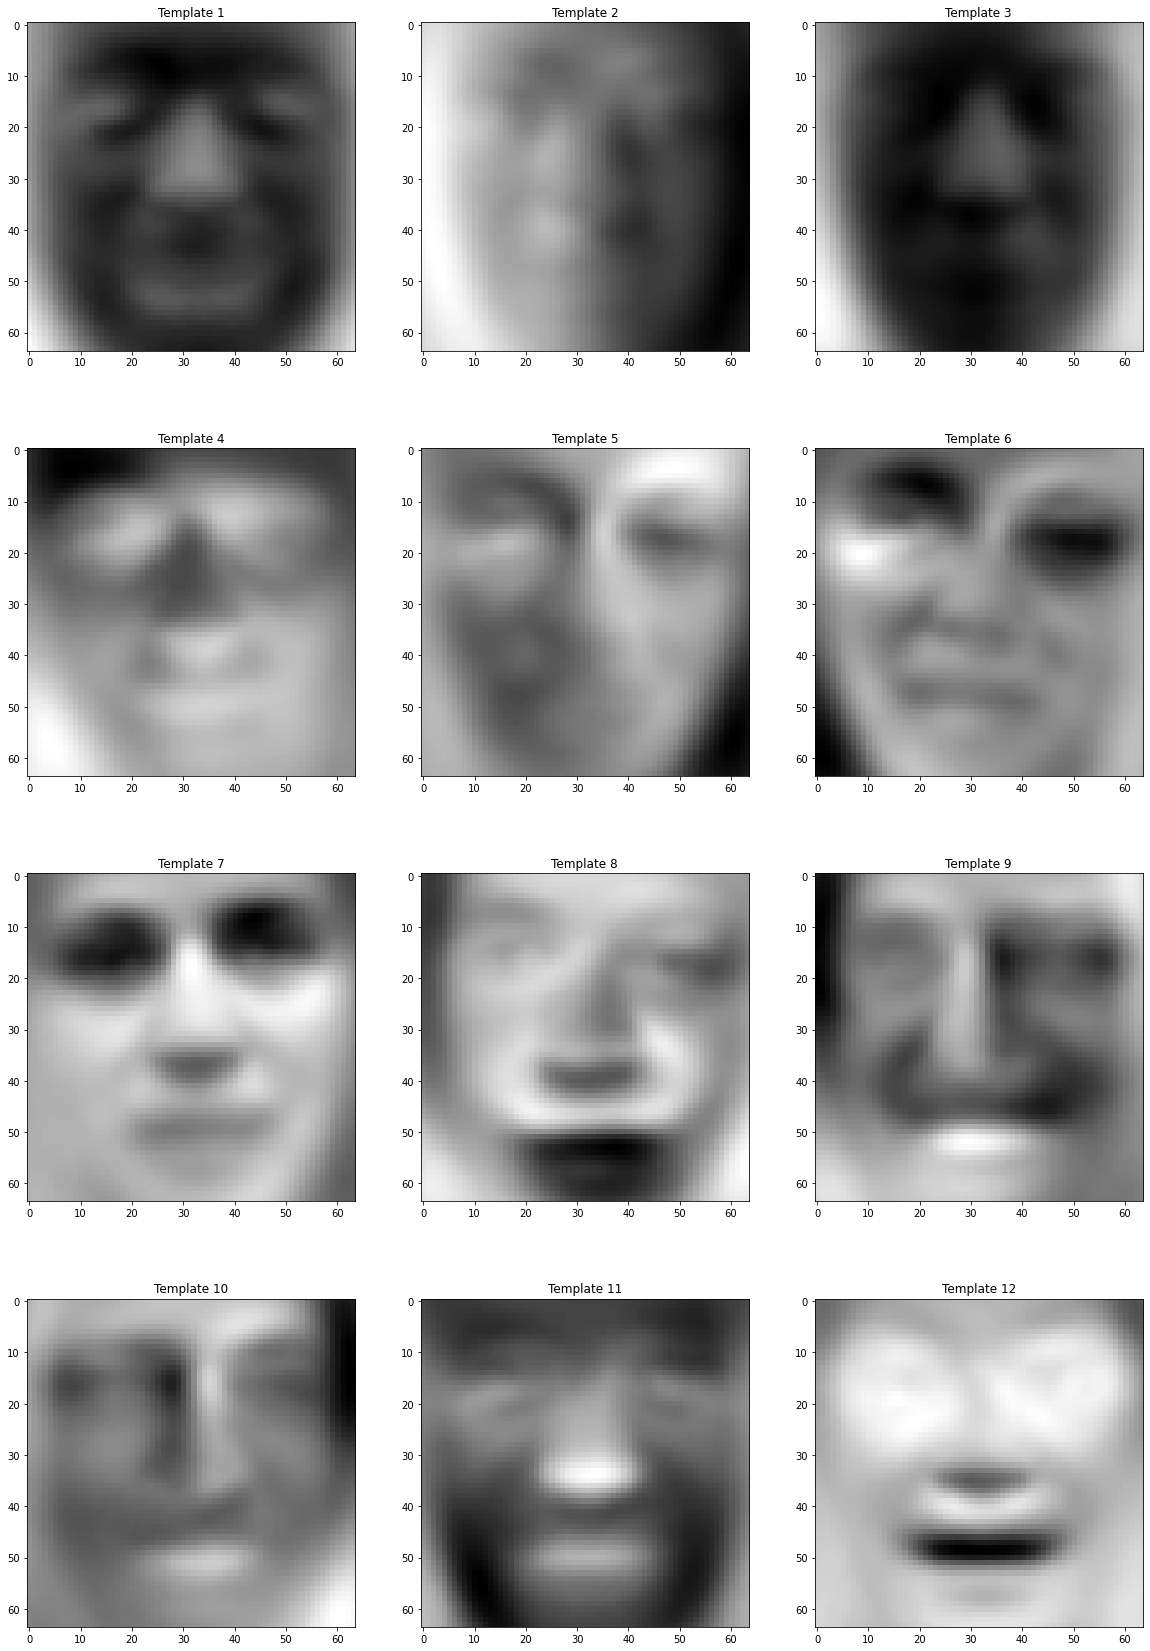

In [ ]:
basis = projection_matrix.reshape(64, 64, required_dim)

plt.figure(figsize=(20, 30))

for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(basis[:,:,i], 'gray')
    plt.title('Template {}'.format(i+1))

## Project the data on the new basis

In [ ]:
# Matrix multiply X(13233, 4096) with projection_matrix(4096, 577)
projected_data = X.dot(projection_matrix)  # (13233, 577)

print(projected_data.shape)

(13233, 577)


## Visualize reconstructed data

Label Gloria_Macapagal_Arroyo_0022.pgm


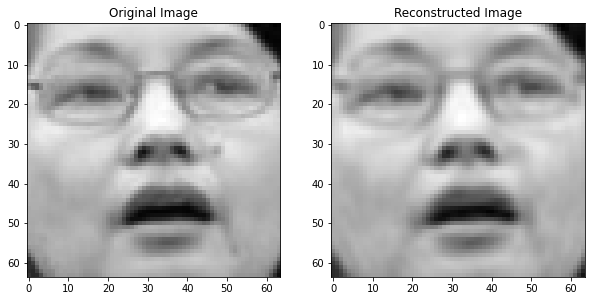

In [ ]:
import random

# index of the image to reconstruct
index = random.randint(0,13233)

projected_image= np.expand_dims(projected_data[index], 0)  # (1, num_dims)

# Matrix multiply projected_image(1, num_dims) with projection_matrix transposed(num_dims, 784)
reconstructed_image = projected_image.dot(projection_matrix.T)  # (1, 784)
reconstructed_image = reconstructed_image.reshape(64, 64)

print('Label {}'.format(filenames[index]))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(images[index], 'gray')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, 'gray')

## Compare Same Person's Faces

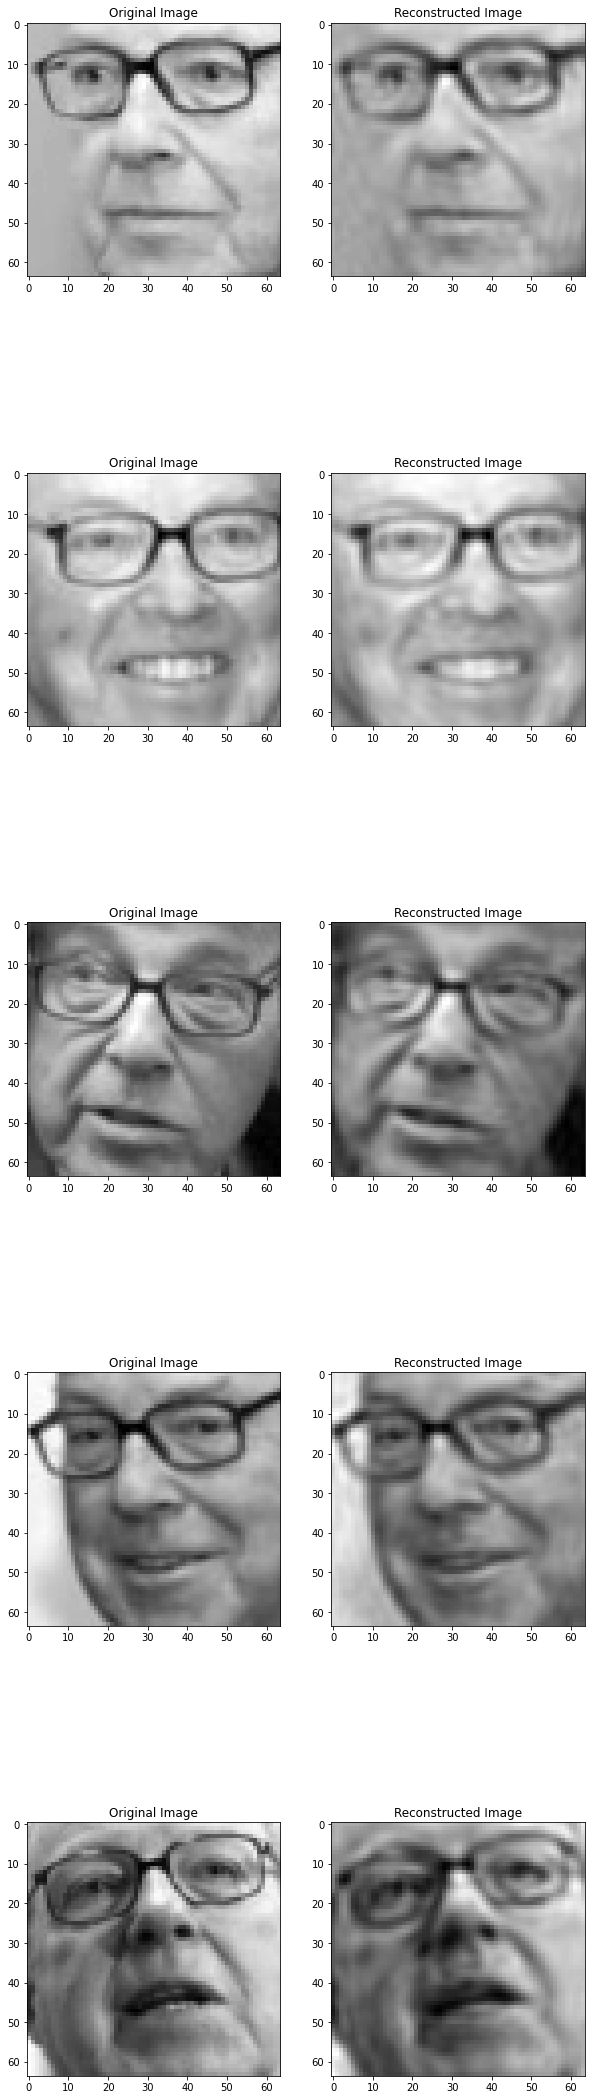

In [ ]:
indexes = np.array([index for index, filename in enumerate(filenames) if filename.startswith('Hans_Blix')])

# Reconstruct the required images
projected_images = projected_data[indexes]
reconstructed_images = projected_images.dot(projection_matrix.T)  # (num_images, 784)
reconstructed_images = reconstructed_images.reshape(indexes.shape[0], 64, 64)

plt.figure(figsize=(10, 40))

for i in range(5):

    plt.subplot(5, 2, 2*i+1)
    plt.title('Original Image')
    plt.imshow(images[indexes[i]], 'gray')

    plt.subplot(5, 2, 2*i+2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_images[i], 'gray')